In [2]:
from random import choice
from typing_extensions import TypedDict, Annotated, Optional,Literal, List
from operator import add
from pydantic import BaseModel
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

## **Replacing Typed Dict with Pydantic**
- All we have to do is to replaced TypedDict with BaseModel from Pydantic framework
- The main advantage is that Pydantic provides type checking

In [5]:
class State(BaseModel):
    input_color: Literal["green", "yellow", "red"]
    output_color: Optional[Literal["green", "yellow", "red"]] = None

def color_node(state: State):
    print(f"input_color: {state.input_color}")
    return {"output_color": choice(["green", "yellow", "red"])}

workflow = StateGraph(State)
workflow.add_node(color_node)
workflow.add_edge(START, "color_node")
workflow.add_edge("color_node", END)

graph = workflow.compile()

In [15]:
output = graph.invoke({"input_color": "green"})
print(f"output_color: {output['output_color']}")

input_color: green
output_color: red


## **Graph State Management (State Machines Pattern)**
- The Graph Workflow uses State Machines Pattern to manage state transition
- The State Machines is the set of rules that govern the system transition from one state to another


In [16]:
class State(BaseModel):
    color: Optional[Literal["🟢 Green", "🟡 Yellow", "🔴 Red"]] = None
    repeat_mode: bool
    messages: Annotated[List[str], add] = []
    counter: Annotated[int, add] = 0

In [17]:
def green_light(state: State):
    color = "🟢 Green"
    wait_time = 60
    message = f"{color} Light! Traffic allowed for {wait_time} seconds..."
    messages = [message]
    return {"color": color, "messages": messages, "counter":1}

def yellow_light(state: State):
    color = "🟡 Yellow"
    wait_time = 3
    message = f"{color} Light! Traffic will change in {wait_time} seconds..."
    messages = [message]
    return {"color": color, "messages": messages}

def red_light(state: State):
    counter = state.counter
    color = "🔴 Red"
    wait_time = 15
    message = f"{color} Light! Traffic allowed for {wait_time} seconds..."
    messages = [message]
    messages.append("----------------------------------------------------")
    return {"color": color, "messages": messages}


In [18]:
workflow = StateGraph(State)

In [19]:
workflow.add_node(green_light)
workflow.add_node(yellow_light)
workflow.add_node(red_light)

In [20]:
workflow.add_edge(START, "green_light")
workflow.add_edge("green_light", "yellow_light")
workflow.add_edge("yellow_light", "red_light")

def should_repeat(state: State):
    repeat_mode = state.repeat_mode
    counter = state.counter
    if repeat_mode and counter <= 3:
        return "green_light"
    return END

workflow.add_conditional_edges(
    "red_light",
    should_repeat,
    ["green_light", END],
)

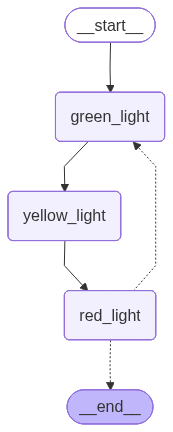

In [21]:
graph = workflow.compile()

display(
    Image(
        graph.get_graph().draw_mermaid_png()
    )
)

In [22]:
print("🚦------------ TRAFFIC LIGHT CONTROLLER ------------🚦")
controller = graph.invoke({"repeat_mode":False})
for message in controller['messages']:
    print(message)

🚦------------ TRAFFIC LIGHT CONTROLLER ------------🚦
🟢 Green Light! Traffic allowed for 60 seconds...
🟡 Yellow Light! Traffic will change in 3 seconds...
🔴 Red Light! Traffic allowed for 15 seconds...
----------------------------------------------------
